# BDA학회 데이터 분석 전처리 적용반 2주차 필수과제

제출자 성명: 이승섭89

scikit-learn에서 제공하는 California Housing 데이터를 covariance-filtering으로 전처리합니다.

전체 데이터셋을 이용한 모델의 MSE와 비교하고 고찰합니다.

Python 3.10.14 버전을 사용합니다.

## 0. Import Required Libraries
필요한 라이브러리를 불러옵니다.

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from sklearn.linear_model import Lasso

## 1. Prepare and Analyze Dataset
California Housing 데이터를 불러오고 특성을 조사합니다.

### 0. Import dataset

In [2]:
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

### 1. Analyze Data

In [3]:
# Read description, check HEAD, and check INFO
print(california.DESCR)
print(X.head())
print(y[:5])
print(X.info())

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

### 2. Analyze Correlation

In [4]:
corr_matrix = pd.concat([X, pd.Series(y, name="MedHouseVal")], axis=1).corr()
print("\nCorrelation matrix:\n", corr_matrix)


Correlation matrix:
                MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc       1.000000 -0.119034  0.326895  -0.062040    0.004834  0.018766   
HouseAge    -0.119034  1.000000 -0.153277  -0.077747   -0.296244  0.013191   
AveRooms     0.326895 -0.153277  1.000000   0.847621   -0.072213 -0.004852   
AveBedrms   -0.062040 -0.077747  0.847621   1.000000   -0.066197 -0.006181   
Population   0.004834 -0.296244 -0.072213  -0.066197    1.000000  0.069863   
AveOccup     0.018766  0.013191 -0.004852  -0.006181    0.069863  1.000000   
Latitude    -0.079809  0.011173  0.106389   0.069721   -0.108785  0.002366   
Longitude   -0.015176 -0.108197 -0.027540   0.013344    0.099773  0.002476   
MedHouseVal  0.688075  0.105623  0.151948  -0.046701   -0.024650 -0.023737   

             Latitude  Longitude  MedHouseVal  
MedInc      -0.079809  -0.015176     0.688075  
HouseAge     0.011173  -0.108197     0.105623  
AveRooms     0.106389  -0.027540     0.151948  
AveBe

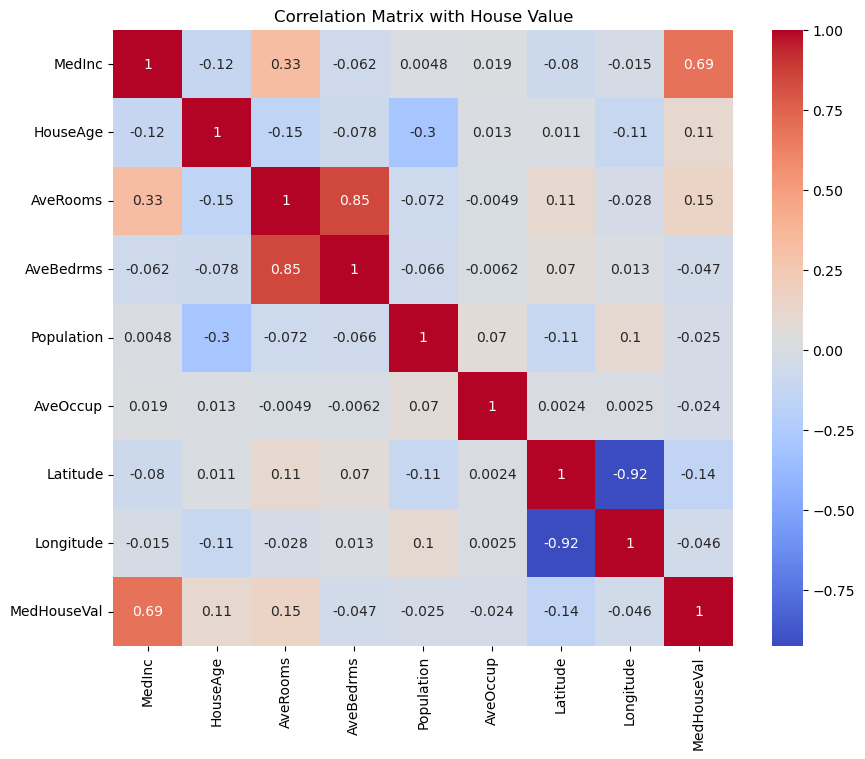

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix with House Value")
plt.show()

## 2. Train and Evaluation Function
주어진 feature과 label에 대해 학습하고 평가하는 함수를 정의합니다.

이 때 모델은 LinearRegression() 모델을 사용합니다.

In [6]:
# Train and evaluation function
def train_and_evaluate(X, y, feature_set_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"MSE with {feature_set_name}: {mse}")
    return mse

## 3. Various Filters

전체 feature 사용, correlation filter, SelectKBest, Recursive Feature Elimination, Mutual Information Filtering, Lasso 등 여러 filter 기법으로 X를 전처리합니다.

Correlation: Feature과 label 간 상관계수 중 임계값 이상의 상관계수를 가진 feature만 사용합니다.

SelectKBest: 등분산 통계기법인 f_regression에 의해 상위 k개의 feature를 선택합니다.

RFE: 영향이 가장 적은 feature를 재귀적으로 제거합니다.

Mutual Information Filtering: Feature과 label의 종속성을 판단해 선별합니다. Nonlinear relation도 측정이 가능합니다.

Lasso (L1 regularization): L1 정규화로 feature를 filter합니다.

### 0. Define filter functions

In [7]:
def correlation_filter(X, threshold=0.1):

    selected_features = corr_matrix['MedHouseVal'][abs(corr_matrix['MedHouseVal']) > threshold].index.drop('MedHouseVal')
    X_filtered = X[selected_features]
    print(f"Features selected after Correlation Threshold: {selected_features}")
    
    return pd.DataFrame(X_filtered, columns=selected_features)

In [8]:
def select_k_best_filter(X, y, k=4):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_filtered = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    print(f"Features selected after SelectKBest filtering: {selected_features}")
    
    return pd.DataFrame(X_filtered, columns=selected_features)

In [9]:
def rfe_filter(X, y, n_features=4):

    model = LinearRegression()
    selector = RFE(model, n_features_to_select=n_features)
    X_filtered = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    print(f"Features selected after RFE: {selected_features}")

    return pd.DataFrame(X_filtered, columns=selected_features)

In [10]:
def mutual_info_filter(X, y, k=4):
    
    mi = mutual_info_regression(X, y)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    selected_features = mi_series.head(k).index
    print(f"Features selected based on mutual information: {selected_features}")
    
    return X[selected_features]

In [11]:
def lasso_filter(X, y, alpha=0.15):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    selected_features = X.columns[lasso.coef_ != 0]
    print(f"Features selected by Lasso: {selected_features}")
    
    return X[selected_features]

### 1. Apply filters to features

In [12]:
# All features
X_all = X

# Correlation Threshold
X_corr = correlation_filter(X)

# SelectKBest
X_kbest = select_k_best_filter(X, y)

# RFE
X_rfe = rfe_filter(X, y)

# Mutual Information
X_mi = mutual_info_filter(X, y)

# Lasso
X_lasso = lasso_filter(X, y)

Features selected after Correlation Threshold: Index(['MedInc', 'HouseAge', 'AveRooms', 'Latitude'], dtype='object')
Features selected after SelectKBest filtering: Index(['MedInc', 'HouseAge', 'AveRooms', 'Latitude'], dtype='object')
Features selected after RFE: Index(['MedInc', 'AveBedrms', 'Latitude', 'Longitude'], dtype='object')
Features selected based on mutual information: Index(['Longitude', 'MedInc', 'Latitude', 'AveRooms'], dtype='object')
Features selected by Lasso: Index(['MedInc', 'HouseAge', 'Population', 'AveOccup', 'Latitude'], dtype='object')


### 2. Calculate MSE for each method

In [13]:
filtered_features = {
    "All Features": X_all,
    "Correlation Threshold": X_corr,
    "SelectKBest": X_kbest,
    "RFE": X_rfe,
    "Mutual Information": X_mi,
    "Lasso": X_lasso
}

for feature_set_name, X_filtered in filtered_features.items():
    train_and_evaluate(X_filtered, y, feature_set_name)

MSE with All Features: 0.5405661575783067
MSE with Correlation Threshold: 0.667247308921566
MSE with SelectKBest: 0.667247308921566
MSE with RFE: 0.5643769034924259
MSE with Mutual Information: 0.569989794897402
MSE with Lasso: 0.6687890924822154


In [14]:
#Blank cell for running entire notebook.

## 4. Conclusions
의외로 모든 feature을 사용하는 모델의 MSE가 가장 낮게 측정되었다.

이는 현재 feature들이 label을 예측하는데 전부 어느 정도 사용이 된다는 얘기인데, Correlation matrix에서는 예상할 수 없는 내용이라서 신기했다.

부동산에 대해 아는 것은 없지만, 어쩌면 경제적인 지표나 환경적인 지표가 들어가면 더 좋은 모델이 될 것 같았다. 예를 들어 나라 GDP, 혹은 구매 당시 기온 같은 정보도 도움이 되지 않을까?